In [ ]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from ast import literal_eval

## data gathering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/20210810.csv')

In [ ]:
df.info()

In [ ]:
papers = df[['tmdbId', 'title','overview', 'year']]
papers.head()

,tmdbId,title,overview,year
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1995
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,1995
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,1995
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",1995
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,1995


In [ ]:
papers = papers.rename(columns={'overview':'paper_text'})
papers.head()

,tmdbId,title,paper_text,year
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",1995
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,1995
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,1995
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",1995
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,1995


In [ ]:
papers['paper_text'].astype(str)

0        Led by Woody, Andy's toys live happily in his ...
1        When siblings Judy and Peter discover an encha...
2        A family wedding reignites the ancient feud be...
3        Cheated on, mistreated and stepped on, the wom...
4        Just when George Banks has recovered from his ...
                               ...                        
45025    A film archivist revisits the story of Rustin ...
45026    It's the year 3000 AD. The world's most danger...
45027    Yet another version of the classic epic, with ...
45028    An artist struggles to finish his work while a...
45029    When one of her hits goes wrong, a professiona...
Name: paper_text, Length: 45030, dtype: object

In [ ]:
papers[papers['paper_text'].isna()]

,tmdbId,title,paper_text,year
32,78802,Wings of Courage,NaN,1996
299,161495,Roommates,NaN,1995
633,287305,Peanuts – Die Bank zahlt alles,NaN,1996
634,339428,Happy Weekend,NaN,1996
640,10801,The Superwife,NaN,1996
...,...,...,...,...
44924,395767,Scribe,NaN,2017
44925,199887,Over/Under,NaN,2013
44960,317389,Simbad e il califfo di Bagdad,NaN,1973
44977,468707,Thick Lashes of Lauri Mäntyvaara,NaN,2017


In [ ]:
papers = papers.dropna()

In [ ]:
papers[papers['paper_text'].isna()]

,tmdbId,title,paper_text,year


## topic modelling - corpus and dictionary

In [ ]:
import spacy
spacy.load('en')
from spacy.lang.en import English
parser = English()
def tokenize(text):
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [ ]:
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma
    
from nltk.stem.wordnet import WordNetLemmatizer
def get_lemma2(word):
    return WordNetLemmatizer().lemmatize(word)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [get_lemma(token) for token in tokens]
    return tokens

In [ ]:
import random
text_data = []
#with papers as f:
for line in papers['paper_text']:
    tokens = prepare_text_for_lda(line)
    if random.random() > .99:
        print(tokens)
        text_data.append(tokens)

['provincial', 'relate', 'shanghai', 'crime', 'family', 'recruit', 'uncle', 'cosmopolitan', 'shanghai', '1930s', 'servant', 'ganglord', 'mistress']
['american', 'romantic', 'comedy', 'young', 'obsess', 'traffic', 'gridlock', 'falls', 'avant', 'garde', 'dancer']
['jennifer', 'alicia', 'silverstone', 'lovely', 'hire', 'harry', 'tucker', 'walsh', 'dolly', 'garlington', 'tucker', 'party', 'proceed', 'inebriate', 'tucker', 'fantasize', 'beautiful', 'sitter', 'meanwhile', 'jeremy', 'london', 'boyfriend', 'nicky', 'another', 'interest', 'decide', 'jennifer', 'tucker', 'house', 'young', 'fixate']
['base', 'story', 'juliet', 'hulme', 'pauline', 'parker', 'close', 'friend', 'share', 'fantasy', 'literature', 'conspire', 'pauline', 'mother', 'try', 'girl', 'intense', 'obsessive', 'relationship']
['young', 'marines', 'suicide', 'mission', 'vietnam', 'struggle', 'survival', 'jungle', 'minefield', 'street', 'prepare']
['analyst', 'draw', 'illegal', 'fight', 'government', 'colombian', 'cartel']
['emer

In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 3.9 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=7527a4f6babf916d2d655112af1bb24b838d7c49c4f3bd0633b64722657b3cb5
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
## LDA with Gensim
## create the dictionary and corpus
## 여기가 젤 중요 base

from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')
print('Total Vocabulary Size:', len(corpus))

Total Vocabulary Size: 444


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


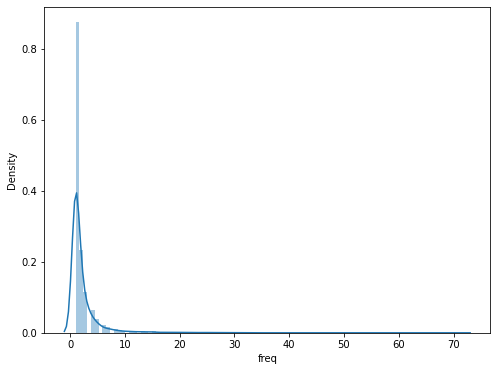

In [ ]:
## frequency


dict_corpus = {}

for i in range(len(corpus)):
  for idx, freq in corpus[i]:
    if dictionary[idx] in dict_corpus:
      dict_corpus[dictionary[idx]] += freq
    else:
       dict_corpus[dictionary[idx]] = freq
       
dict_df = pd.DataFrame.from_dict(dict_corpus, orient='index', columns=['freq'])

plt.figure(figsize=(8,6))
sns.distplot(dict_df['freq'], bins=100);

In [ ]:
dict_df.sort_values('freq', ascending=False).head(10)


,freq
world,71
young,60
woman,53
story,50
become,49
family,48
father,44
take,38
friend,38
years,32


## mallet 말고

In [ ]:
## 5개 토픽

import gensim
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model5.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.006*"become" + 0.005*"story" + 0.004*"murder" + 0.003*"around"')
(1, '0.005*"people" + 0.004*"woman" + 0.004*"world" + 0.004*"friend"')
(2, '0.010*"world" + 0.006*"family" + 0.005*"young" + 0.005*"become"')
(3, '0.005*"mother" + 0.005*"father" + 0.005*"woman" + 0.004*"family"')
(4, '0.006*"young" + 0.005*"story" + 0.005*"group" + 0.004*"world"')


In [ ]:
!pip install pyLDAvis==2.1.2
import gensim
import pyLDAvis


In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model5.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

In [ ]:
## 10개 토픽

import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model10.gensim')
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

In [ ]:
dictionary = gensim.corpora.Dictionary.load('dictionary.gensim')
corpus = pickle.load(open('corpus.pkl', 'rb'))
lda = gensim.models.ldamodel.LdaModel.load('model10.gensim')
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
pyLDAvis.save_html(lda_display, 'lda10_0810.html')

## using mallet

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip


--2021-08-12 10:27:54--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.74MB/s    in 3.3s    

2021-08-12 10:27:58 (4.74 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]



In [ ]:
!unzip mallet-2.0.8.zip


In [ ]:
mallet_path = '/content/mallet-2.0.8/bin/mallet'

In [ ]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=dictionary)


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
from pprint import pprint
# display topics
pprint(ldamallet.show_topics(formatted=False))

In [ ]:
# Compute Coherence Score
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts= text_data, dictionary= dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('Coherence Score: ', coherence_ldamallet)

Coherence Score:  0.45100524582115203


### optimal number K


In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=text_data, start=2, limit=40, step=6)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is

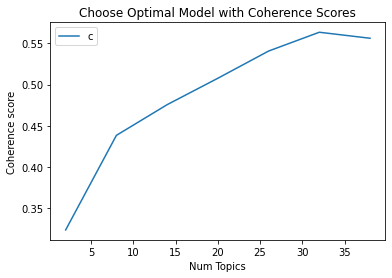

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Choose Optimal Model with Coherence Scores")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3237
Num Topics = 8  has Coherence Value of 0.4383
Num Topics = 14  has Coherence Value of 0.4755
Num Topics = 20  has Coherence Value of 0.5076
Num Topics = 26  has Coherence Value of 0.5406
Num Topics = 32  has Coherence Value of 0.5634
Num Topics = 38  has Coherence Value of 0.5561


### come back to the list 

In [ ]:
import pickle
pickle.dump(ldamallet, open("drive/My Drive/ldamallet.pkl", "wb"))

In [ ]:
tm_results = ldamallet[corpus]


/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
corpus_topics = [sorted(topics, key=lambda record: -record[1])[0] for topics in tm_results]

In [ ]:
topics = [[(term, round(wt, 3)) for term, wt in ldamallet.show_topic(n, topn=20)] for n in range(0, ldamallet.num_topics)]

In [ ]:
topics_df = pd.DataFrame([[term for term, wt in topic] for topic in topics], columns = ['Term'+str(i) for i in range(1, 21)], index=['Topic '+str(t) for t in range(1, ldamallet.num_topics+1)]).T
topics_df.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Term1,life,family,world,mother,story,woman,people,series,father,years
Term2,daughter,find,relationship,group,base,young,problem,turn,friend,force
Term3,decide,young,survive,bring,american,death,documentary,found,discover,kill
Term4,escape,meet,place,return,school,attempt,local,director,murder,power
Term5,change,prison,college,movie,event,things,show,involve,night,battle


In [ ]:
# set column width
pd.set_option('display.max_colwidth', -1)
topics_df = pd.DataFrame([', '.join([term for term, wt in topic]) for topic in topics], columns = ['Terms per Topic'], index=['Topic'+str(t) for t in range(1, ldamallet.num_topics+1)] )
topics_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,Terms per Topic
Topic1,"life, daughter, decide, escape, change, child, small, struggle, police, german, call, arrange, demon, guard, future, feel, security, convince, haunt, travel"
Topic2,"family, find, young, meet, prison, order, sister, island, husband, worker, revenge, release, money, commit, business, childhood, christmas, girlfriend, detective, wrong"
Topic3,"world, relationship, survive, place, college, break, follow, realize, friendship, play, experience, happen, belief, married, imagine, means, victim, alien, arrive, plan"
Topic4,"mother, group, bring, return, movie, create, start, owner, house, fight, station, powerful, agent, lead, leading, suddenly, quickly, confront, professor, killing"
Topic5,"story, base, american, school, event, white, student, crime, present, parent, movie, hope, generation, short, member, japanese, village, produce, teenager, revolve"
Topic6,"woman, young, death, attempt, things, boyfriend, wedding, marry, reveal, hunter, unite, earth, working, lover, continue, humans, criminal, search, zombie, trial"
Topic7,"people, problem, documentary, local, show, journey, personal, character, living, feature, black, begin, make, female, history, class, music, dream, comedy, star"
Topic8,"series, turn, found, director, involve, direct, write, include, accident, russian, million, writer, film, star, drama, catch, society, stand, television, running"
Topic9,"father, friend, discover, murder, night, couple, begin, brother, beautiful, michael, doctor, mysterious, party, horror, teenage, strange, falls, killer, stranger, state"
Topic10,"years, force, kill, power, battle, learn, secret, rescue, destroy, mission, special, terrorist, legend, control, soldier, entire, human, enemy, truth, recover"


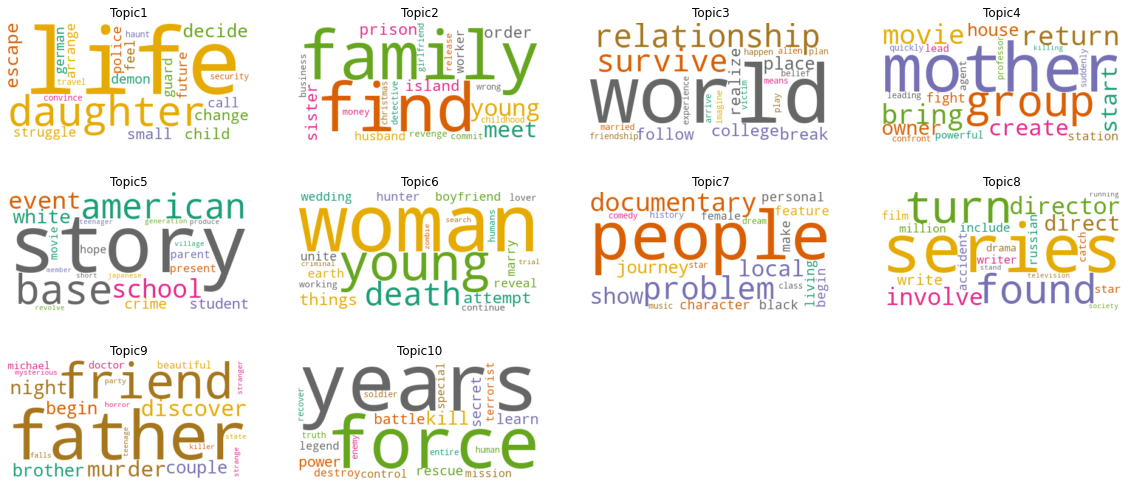

In [ ]:
## Wordclouds
# import wordclouds
from wordcloud import WordCloud

# initiate wordcloud object
wc = WordCloud(background_color="white", colormap="Dark2", max_font_size=150, random_state=42)

# set the figure size
plt.rcParams['figure.figsize'] = [20, 15]

# Create subplots for each topic
for i in range(10):

    wc.generate(text=topics_df["Terms per Topic"][i])
    
    plt.subplot(5, 4, i+1)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(topics_df.index[i])

plt.show()

In [ ]:
## visualisation with pyLDAvis

from gensim.models.ldamodel import LdaModel

def convertldaMalletToldaGen(mallet_model):
    model_gensim = LdaModel(
        id2word=mallet_model.id2word, num_topics=mallet_model.num_topics,
        alpha=mallet_model.alpha) 
    model_gensim.state.sstats[...] = mallet_model.wordtopics
    model_gensim.sync_state()
    return model_gensim

In [ ]:
ldagensim = convertldaMalletToldaGen(ldamallet)

In [ ]:
!pip install pyLDAvis==2.1.2

In [ ]:
vis_data = pyLDAvis.gensim.prepare(ldagensim, corpus, dictionary, sort_topics=False)
pyLDAvis.display(vis_data)

In [ ]:
pyLDAvis.save_html(vis_data, 'mallet_0812.html')

### sentence

In [ ]:
data = papers['paper_text'].tolist()

In [ ]:
def format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamallet, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)
/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning: This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information
  warnings.warn(message, category=DeprecationWarning)


In [ ]:
# Show
df_dominant_topic[5:10]

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
5,5,9.0,0.1228,"murder, change, brother, girlfriend, movie, survive, living, realize, relationship, start","Obsessive master thief, Neil McCauley leads a top-notch crew on various insane heists throughout Los Angeles while a mentally unstable detective, Vincent Hanna pursues him without rest. Each man recognizes and respects the ability and the dedication of the other even though they are aware their cat-and-mouse game may end in violence."
6,6,7.0,0.1694,"group, kill, attempt, bring, place, event, move, revenge, arrange, plan","An ugly duckling having undergone a remarkable change, still harbors feelings for her crush: a carefree playboy, but not before his business-focused brother has something to say about it."
7,7,9.0,0.2286,"murder, change, brother, girlfriend, movie, survive, living, realize, relationship, start","A mischievous young boy, Tom Sawyer, witnesses a murder by the deadly Injun Joe. Tom becomes friends with Huckleberry Finn, a boy with no future and no family. Tom has to choose between honoring a friendship or honoring an oath because the town alcoholic is accused of the murder. Tom and Huck go through several adventures trying to retrieve evidence."
8,8,4.0,0.3143,"story, decide, mother, sister, child, order, husband, german, fight, arrive","International action superstar Jean Claude Van Damme teams with Powers Boothe in a Tension-packed, suspense thriller, set against the back-drop of a Stanley Cup game.Van Damme portrays a father whose daughter is suddenly taken during a championship hockey game. With the captors demanding a billion dollars by game's end, Van Damme frantically sets a plan in motion to rescue his daughter and abort an impending explosion before the final buzzer..."
9,9,8.0,0.1434,"world, daughter, american, star, director, michael, break, direct, write, movie",James Bond must unmask the mysterious head of the Janus Syndicate and prevent the leader from utilizing the GoldenEye weapons system to inflict devastating revenge on Britain.


In [ ]:
# find the most representative document for each topic

# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.2891,"young, woman, death, beautiful, state, call, earth, wedding, married, hunter","Kathy is married to Peter. Now she can't help but wonder how things could have been if she got together with her old boyfriend, Tom. Being married prevents from doing that so she asks her friend, Emily to go to him and see if she can sleep with him then tell Kathy how it was. When Emily tells Kathy that things were awesome, their friendship suffers, at the same so does Kathy's marriage. Things get even more complicated when Emily learns she's pregnant, and she's not certain if it's Tom's or her boyfriend, Elliot."
1,1.0,0.3367,"years, force, begin, power, battle, turn, island, crime, worker, rescue","Covering the life and times of one of the West's most iconic heroes Wyatt Earp weaves an intricate tale of Earp and his friends and family. With a star studded cast, sweeping cinematography and authentic costumes Wyatt Earp led the way during the Western revival in the 90's."
2,2.0,0.3420,"night, series, school, base, couple, return, small, found, college, falls","Gilbert has to care for his brother Arnie and his obese mother, which gets in the way when love walks into his life."
3,3.0,0.2881,"family, father, life, escape, prison, meet, learn, owner, house, white","Allegedly based on a true story, this film follows the life of Toshi, a Japanese man living in America and working with the New York City police. After being recommended for undercover work, Toshi decides to go after a gang lead by Hawk. Hawk and Toshi soon become friends, although Hawk's second-in-command, Tito, is suspicious of the newcomer. Will Toshi be able to bring the gang down, or will his cover be blown before he can finish the assignment?"
4,4.0,0.3143,"story, decide, mother, sister, child, order, husband, german, fight, arrive","International action superstar Jean Claude Van Damme teams with Powers Boothe in a Tension-packed, suspense thriller, set against the back-drop of a Stanley Cup game.Van Damme portrays a father whose daughter is suddenly taken during a championship hockey game. With the captors demanding a billion dollars by game's end, Van Damme frantically sets a plan in motion to rescue his daughter and abort an impending explosion before the final buzzer..."
5,5.0,0.3810,"people, documentary, problem, show, create, black, include, feature, russian, class","A passenger train has been hijacked by an electronics expert and turned into an untraceable command center for a weapons satellite. He has planned to blow up Washington DC and only one man can stop him, former Navy SEAL Casey Ryback."
6,6.0,0.2726,"friend, discover, find, things, doctor, involve, follow, struggle, make, female","When two unemployed telephone pranksters decide to use their vocal ""talents"" to impersonate a Chicago mob boss and curry favor with organized crime in New York, the trouble begins. It isn't long before Johnny and Kamal (the ""Jerky Boys"" of crank call fame) are wanted by the local mafia, the police, and their neighbor."
7,7.0,0.2500,"group, kill, attempt, bring, place, event, move, revenge, arrange, plan","Five young marines on a suicide mission in Vietnam, struggle for survival in a jungle minefield. The mean streets of home did not prepare them for this."
8,8.0,0.3423,"world, daughter, american, star, director, michael, break, direct, write, movie","On Mitch Robbins 40th birthday begins quite well until he returns home and finds his brother Glen, the black sheep of the family, in his sofa. Nevertheless he is about to have a wonderful birthday-night with his wife when he discovers a treasure map of Curly by chance. Together with Phil and unfortunately with Glen he tries to find the hidden gold of Curly's father in the desert of Arizona."
9,9.0,0.2641,"murder, change, brother, girlfriend, movie, survive, living, realize, relationship, start","This movie chronicles the life and times of R. Crumb. Robert Crumb is the cartoonist/artist 

In [ ]:
sent_topics_sorteddf_mallet.to_csv('./topic_text.csv')

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head()

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"years, force, begin, power, battle, turn, island, crime, worker, rescue",47.0,0.1059
1.0,6.0,"friend, discover, find, things, doctor, involve, follow, struggle, make, female",47.0,0.1059
2.0,2.0,"night, series, school, base, couple, return, small, found, college, falls",50.0,0.1126
3.0,6.0,"friend, discover, find, things, doctor, involve, follow, struggle, make, female",47.0,0.1059
4.0,0.0,"young, woman, death, beautiful, state, call, earth, wedding, married, hunter",33.0,0.0743


### dominant topics for each document

In [ ]:
# create a dataframe
corpus_topic_df = pd.DataFrame()
# get the Titles from the original dataframe
#corpus_topic_df['Title'] = papers.tmdbId
corpus_topic_df['Dominant Topic'] = [item[0]+1 for item in corpus_topics]
corpus_topic_df['Contribution %'] = [round(item[1]*100, 2) for item in corpus_topics]
corpus_topic_df['Topic Terms'] = [topics_df.iloc[t[0]]['Terms per Topic'] for t in corpus_topics]
corpus_topic_df

,Dominant Topic,Contribution %,Topic Terms
0,5,14.64,"story, base, american, school, event, white, student, crime, present, parent, movie, hope, generation, short, member, japanese, village, produce, teenager, revolve"
1,6,12.39,"woman, young, death, attempt, things, boyfriend, wedding, marry, reveal, hunter, unite, earth, working, lover, continue, humans, criminal, search, zombie, trial"
2,6,19.55,"woman, young, death, attempt, things, boyfriend, wedding, marry, reveal, hunter, unite, earth, working, lover, continue, humans, criminal, search, zombie, trial"
3,5,19.77,"story, base, american, school, event, white, student, crime, present, parent, movie, hope, generation, short, member, japanese, village, produce, teenager, revolve"
4,10,16.21,"years, force, kill, power, battle, learn, secret, rescue, destroy, mission, special, terrorist, legend, control, soldier, entire, human, enemy, truth, recover"
...,...,...,...
439,1,18.88,"life, daughter, decide, escape, change, child, small, struggle, police, german, call, arrange, demon, guard, future, feel, security, convince, haunt, travel"
440,4,17.46,"mother, group, bring, return, movie, create, start, owner, house, fight, station, powerful, agent, lead, leading, suddenly, quickly, confront, professor, killing"
441,3,13.50,"world, relationship, survive, place, college, break, follow, realize, friendship, play, experience, happen, belief, married, imagine, means, victim, alien, arrive, plan"
442,8,13.40,"series, turn, found, director, involve, direct, write, include, accident, russian, million, writer, film, star, drama, catch, society, stand, television, running"


In [ ]:
dominant_topic_df = corpus_topic_df.groupby('Dominant Topic').agg(
                                  Doc_Count = ('Dominant Topic', np.size),
                                  Total_Docs_Perc = ('Dominant Topic', np.size)).reset_index()

dominant_topic_df['Total_Docs_Perc'] = dominant_topic_df['Total_Docs_Perc'].apply(lambda row: round((row*100) / len(corpus), 2))

dominant_topic_df

,Dominant Topic,Doc_Count,Total_Docs_Perc
0,1,51,11.49
1,2,45,10.14
2,3,37,8.33
3,4,45,10.14
4,5,40,9.01
5,6,58,13.06
6,7,50,11.26
7,8,41,9.23
8,9,41,9.23
9,10,36,8.11


In [ ]:
corpus_topic_df.groupby('Dominant Topic').apply(lambda topic_set: 
                                                (topic_set.sort_values(by=['Contribution %'], ascending=False).iloc[0])).reset_index(drop=True)

,Dominant Topic,Contribution %,Topic Terms
0,1,38.83,"life, daughter, decide, escape, change, child, small, struggle, police, german, call, arrange, demon, guard, future, feel, security, convince, haunt, travel"
1,2,34.95,"family, find, young, meet, prison, order, sister, island, husband, worker, revenge, release, money, commit, business, childhood, christmas, girlfriend, detective, wrong"
2,3,35.02,"world, relationship, survive, place, college, break, follow, realize, friendship, play, experience, happen, belief, married, imagine, means, victim, alien, arrive, plan"
3,4,32.79,"mother, group, bring, return, movie, create, start, owner, house, fight, station, powerful, agent, lead, leading, suddenly, quickly, confront, professor, killing"
4,5,25.20,"story, base, american, school, event, white, student, crime, present, parent, movie, hope, generation, short, member, japanese, village, produce, teenager, revolve"
5,6,31.97,"woman, young, death, attempt, things, boyfriend, wedding, marry, reveal, hunter, unite, earth, working, lover, continue, humans, criminal, search, zombie, trial"
6,7,34.60,"people, problem, documentary, local, show, journey, personal, character, living, feature, black, begin, make, female, history, class, music, dream, comedy, star"
7,8,36.11,"series, turn, found, director, involve, direct, write, include, accident, russian, million, writer, film, star, drama, catch, society, stand, television, running"
8,9,29.96,"father, friend, discover, murder, night, couple, begin, brother, beautiful, michael, doctor, mysterious, party, horror, teenage, strange, falls, killer, stranger, state"
9,10,44.56,"years, force, kill, power, battle, learn, secret, rescue, destroy, mission, special, terrorist, legend, control, soldier, entire, human, enemy, truth, recover"


### distributions over years

In [ ]:
pprint(tm_results[0])


[(0, 0.11666666666666667),
 (1, 0.08333333333333333),
 (2, 0.08703703703703704),
 (3, 0.12222222222222222),
 (4, 0.1574074074074074),
 (5, 0.08888888888888889),
 (6, 0.08333333333333333),
 (7, 0.08333333333333333),
 (8, 0.09444444444444444),
 (9, 0.08333333333333333)]


In [ ]:
df_weights = pd.DataFrame.from_records([{v: k for v, k in row} for row in tm_results])
df_weights.columns = ['Topic ' + str(i) for i in range(1,11)]
df_weights

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
0,0.116667,0.083333,0.087037,0.122222,0.157407,0.088889,0.083333,0.083333,0.094444,0.083333
1,0.103395,0.097222,0.094136,0.070988,0.086420,0.115741,0.100309,0.083333,0.179012,0.069444
2,0.102004,0.094718,0.098361,0.112933,0.083789,0.081967,0.085610,0.145719,0.112933,0.081967
3,0.095517,0.087719,0.107212,0.087719,0.120858,0.115010,0.089669,0.087719,0.120858,0.087719
4,0.120833,0.075000,0.073611,0.065278,0.122222,0.101389,0.090278,0.076389,0.151389,0.123611
...,...,...,...,...,...,...,...,...,...,...
422,0.120858,0.099415,0.087719,0.107212,0.087719,0.093567,0.091618,0.099415,0.107212,0.105263
423,0.109091,0.105051,0.101010,0.092929,0.113131,0.090909,0.092929,0.090909,0.109091,0.094949
424,0.109375,0.093750,0.133681,0.079861,0.105903,0.126736,0.083333,0.098958,0.090278,0.078125
425,0.090909,0.096970,0.109091,0.121212,0.090909,0.090909,0.090909,0.127273,0.090909,0.090909


In [ ]:
df_weights['Year'] = papers.year
df_weights.groupby('Year').mean()


,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10
Year,,,,,,,,,,
1964.0,0.069444,0.069444,0.081790,0.100309,0.203704,0.083333,0.138889,0.080247,0.101852,0.070988
1965.0,0.083333,0.101852,0.069444,0.169753,0.074074,0.081790,0.097222,0.086420,0.149691,0.086420
1967.0,0.076832,0.157210,0.099291,0.127660,0.088652,0.101655,0.063830,0.109929,0.102837,0.072104
1976.0,0.115385,0.096154,0.096154,0.096154,0.096154,0.096154,0.096154,0.096154,0.115385,0.096154
1977.0,0.072222,0.125000,0.118056,0.062500,0.126389,0.062500,0.065278,0.162500,0.081944,0.123611
1992.0,0.108994,0.104536,0.099683,0.100776,0.084145,0.116296,0.091155,0.093316,0.094343,0.106756
1993.0,0.100976,0.098786,0.110163,0.100035,0.098735,0.097645,0.095447,0.100372,0.100187,0.097652
1994.0,0.102188,0.100164,0.100257,0.097581,0.099521,0.100939,0.098693,0.100818,0.099056,0.100784
1995.0,0.100274,0.099626,0.098836,0.100345,0.104287,0.097747,0.100353,0.097809,0.099466,0.101256


In [ ]:
df_weights['Dominant'] = df_weights.drop('Year', axis=1).idxmax(axis=1)
df_weights.head()

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Year,Dominant
0,0.084444,0.094815,0.082963,0.100741,0.068148,0.108148,0.174815,0.088889,0.106667,0.090370,1995.0,Topic 7
1,0.120690,0.097701,0.086207,0.086207,0.134100,0.086207,0.111111,0.086207,0.099617,0.091954,1995.0,Topic 5
2,0.179969,0.140845,0.104851,0.084507,0.070423,0.073552,0.089202,0.078247,0.070423,0.107981,1995.0,Topic 1
3,0.079772,0.069801,0.101140,0.122507,0.103989,0.116809,0.116809,0.082621,0.142450,0.064103,1995.0,Topic 9
4,0.078125,0.123264,0.114583,0.078125,0.095486,0.109375,0.112847,0.086806,0.093750,0.107639,1995.0,Topic 2


In [ ]:
df_dominance = df_weights.groupby('Year')['Dominant'].value_counts(normalize=True).unstack()
df_dominance


Dominant,Topic 1,Topic 10,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Year,,,,,,,,,,
1964.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
1967.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
1976.0,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN
1977.0,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
1992.0,0.200000,NaN,NaN,0.200000,NaN,0.200000,NaN,NaN,0.200000,0.200000
1993.0,0.150000,0.050000,0.050000,0.100000,0.200000,0.100000,0.100000,0.100000,NaN,0.150000
1994.0,0.102941,0.088235,0.102941,0.080882,0.183824,0.066176,0.110294,0.095588,0.044118,0.125000
1995.0,0.118943,0.092511,0.088106,0.088106,0.127753,0.118943,0.066079,0.101322,0.101322,0.096916
